In [1]:
import networkx as nx
import pygeodesy as pg
import pandas as pd
from pygeodesy import ellipsoidalVincenty as ev

In [2]:
# Read file
buildings = pd.read_csv("./buildings.csv")
streets = pd.read_csv("./streets.csv")
edges = pd.read_csv("./edges.csv")

In [3]:
buildings

,name,coordinate,mail_code
0,Engineering Hall,"40.1107778,-88.2291468",266
1,Materials Science and Engineering Building,"40.1108638,-88.2282995",246
2,Illini Union,"\r40.109494, -88.227170",384
3,Noyes Laboratory,"40.108482, -88.226117",712
4,Ischool,"40.107682, -88.231541",493
5,Department of Psychology,"40.107525, -88.229945",142


In [4]:
# Initialize directed graph
my_g = nx.DiGraph()

In [5]:
# add buildings nodes
for x in range(buildings.shape[0]):
    building = buildings.iloc[x]
    my_g.add_node(building["name"],attr_dict={"type": "building","coor":building.coordinate,"mail_code":building.mail_code})

In [6]:
# add streets nodes
"""
for x in range(streets.shape[0]):
    street = streets.iloc[x]
    my_g.add_node(street["name"],attr_dict={"type": "street"})
"""

'\nfor x in range(streets.shape[0]):\n    street = streets.iloc[x]\n    my_g.add_node(street["name"],attr_dict={"type": "street"})\n'

In [7]:
# add intersection nodes
for x in range(edges.shape[0]):
    edge = edges.iloc[x]    
    my_g.add_node(edge.node_a+"-"+edge.node_b,{"type": "intersection","a": edge.node_a,"b": edge.node_b,"coor": edge.intersection})

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def convertBearingToDirection(bearing):
    if bearing >= 45 and bearing < 135:
        goto="East"
    elif bearing >=135 and bearing < 225:
        goto = "South"
    elif bearing >=225 and bearing < 315:
        goto = "West"
    else:
        goto = "North"
    return goto

# add edge
for x in range(edges.shape[0]):
    edge = edges.iloc[x]    
    start = my_g.node[edge.node_a+"-"+edge.node_b]
    if "coor" in start:
        coor = start["coor"].split(",")
        start_coor = ev.LatLon(coor[0],coor[1])
    if edge.node_a in my_g.node:
        end = my_g.node[edge.node_a]
        if "coor" in end:
            coor = end["coor"].split(",")
            end_coor = ev.LatLon(coor[0],coor[1])
            dist, bearing, _  = start_coor.distanceTo3(end_coor)
            goto = convertBearingToDirection(bearing)
            # directed graph
            my_g.add_edge(edge.node_a+"-"+edge.node_b,edge.node_a,{"weight": dist,"bearing": bearing,"goto": goto})
            bearing = bearing+180
            bearing = (bearing - 360) if bearing > 360 else bearing
            goto = convertBearingToDirection(bearing)
            my_g.add_edge(edge.node_a,edge.node_a+"-"+edge.node_b,{"weight": dist,"bearing": bearing,"goto": goto})
        #else:
        #    my_g.add_edge(edge.node_a+"-"+edge.node_b,edge.node_a,{"weight": 0})
        #    my_g.add_edge(edge.node_a,edge.node_a+"-"+edge.node_b,{"weight": 0})
    if edge.node_b in my_g.node:
        end = my_g.node[edge.node_b]
        if "coor" in end:
            coor = end["coor"].split(",")
            end_coor = ev.LatLon(coor[0],coor[1])
            dist, bearing, _  = start_coor.distanceTo3(end_coor)
            goto = convertBearingToDirection(bearing)
            # directed graph
            my_g.add_edge(edge.node_a+"-"+edge.node_b,edge.node_b,{"weight": dist,"bearing": bearing,"goto": goto})
            bearing = bearing+180
            bearing = (bearing - 360) if bearing > 360 else bearing
            goto = convertBearingToDirection(bearing)
            my_g.add_edge(edge.node_b,edge.node_a+"-"+edge.node_b,{"weight": dist,"bearing": bearing,"goto": goto})
        #else:
        #    my_g.add_edge(edge.node_a+"-"+edge.node_b,edge.node_b,{"weight": 0})
        #    my_g.add_edge(edge.node_b,edge.node_a+"-"+edge.node_b,{"weight": 0})

In [10]:
# add edge for street intersections
for x in range(streets.shape[0]):
    street = streets.iloc[x]
    street_name = street["name"]
    node_collection = []
    # select intersection node that have particular street name
    for my_node_key in my_g.node:
        my_node = my_g.node[my_node_key]
#        print(my_node)
        if my_node["type"]=="intersection":
            if my_node["a"] == street_name or my_node["b"]==street_name:
                node_collection.append(my_node_key)
    # compute distance between all node in node_collection
    for node_a in node_collection:
        coor = my_g.node[node_a]["coor"].split(",")
        start_coor = ev.LatLon(coor[0],coor[1])
        for node_b in node_collection:
            if node_a!=node_b:
                coor = my_g.node[node_b]["coor"].split(",")
                end_coor = ev.LatLon(coor[0],coor[1])            
                dist, bearing, _  = start_coor.distanceTo3(end_coor)
                goto = convertBearingToDirection(bearing)
                my_g.add_edge(node_a,node_b,{"weight": dist,"bearing": bearing,"goto": goto})

In [11]:
my_g.node

{'Department of Psychology': {'coor': '40.107525, -88.229945',
  'mail_code': 142,
  'type': 'building'},
 'Department of Psychology-E Daniel St': {'a': 'Department of Psychology',
  'b': 'E Daniel St',
  'coor': '40.107962, -88.229932',
  'type': 'intersection'},
 'Engineering Hall': {'coor': '40.1107778,-88.2291468',
  'mail_code': 266,
  'type': 'building'},
 'Engineering Hall-W Green St': {'a': 'Engineering Hall',
  'b': 'W Green St',
  'coor': '40.1104354,-88.2269561',
  'type': 'intersection'},
 'Illini Union': {'coor': '\r40.109494, -88.227170',
  'mail_code': 384,
  'type': 'building'},
 'Illini Union-W Green St': {'a': 'Illini Union',
  'b': 'W Green St',
  'coor': '40.1103287,-88.227278',
  'type': 'intersection'},
 'Ischool': {'coor': '40.107682, -88.231541',
  'mail_code': 493,
  'type': 'building'},
 'Ischool-E Daniel St': {'a': 'Ischool',
  'b': 'E Daniel St',
  'coor': '40.1079758,-88.2315345',
  'type': 'intersection'},
 'Materials Science and Engineering Building': {'c

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserW

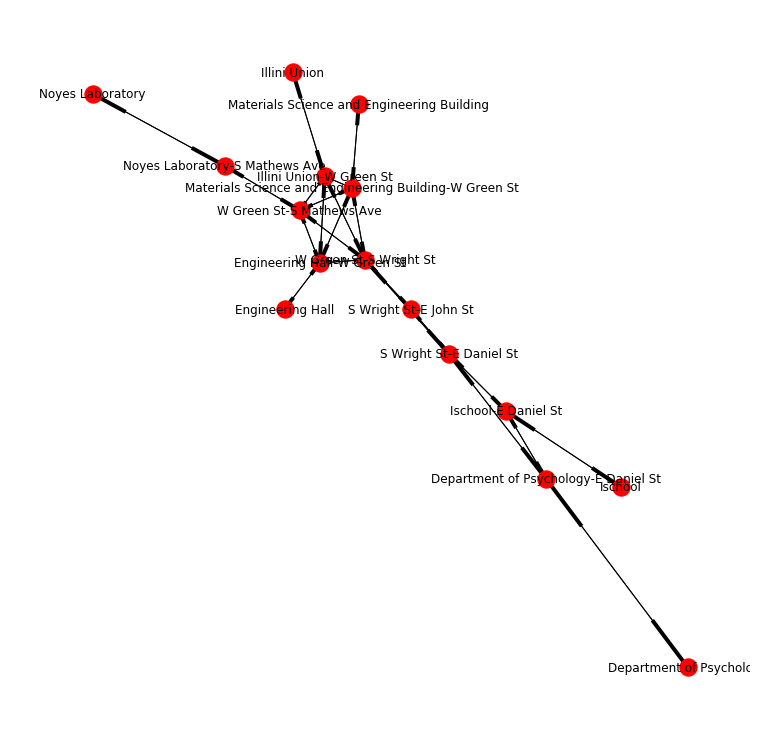

In [24]:
plt.figure(figsize=(10,10))
nx.draw(my_g,with_labels=True)

In [13]:
nx.shortest_path(my_g,"Ischool","Noyes Laboratory",weight="weight")

['Ischool',
 'Ischool-E Daniel St',
 'S Wright St-E Daniel St',
 'W Green St-S Wright St',
 'W Green St-S Mathews Ave',
 'Noyes Laboratory-S Mathews Ave',
 'Noyes Laboratory']

In [14]:
nx.shortest_path(my_g,"Ischool","Department of Psychology",weight="weight")

['Ischool',
 'Ischool-E Daniel St',
 'Department of Psychology-E Daniel St',
 'Department of Psychology']

In [15]:
nx.shortest_path(my_g,"Ischool","Illini Union",weight="weight")

['Ischool',
 'Ischool-E Daniel St',
 'S Wright St-E Daniel St',
 'W Green St-S Wright St',
 'Illini Union-W Green St',
 'Illini Union']

In [20]:
# render output
#shortest = nx.shortest_path(my_g,"Ischool","Illini Union",weight="weight")
shortest = nx.shortest_path(my_g,"Ischool","Department of Psychology",weight="weight")
temp_path = []
total_distance = 0
for i,path in enumerate(shortest):
    #print(my_g.node[path])
    if i == 0:
        start = path 
    if i+1 < len(shortest):
        if i == len(shortest)-1:
            end = shortest[i+1]
        else:    
            my_edge = my_g.edge[path][shortest[i+1]]
            print(shortest[i+1])
            dest_node = my_g.node[shortest[i+1]]
            if dest_node["type"]=="intersection":
                if(dest_node["a"]==start):
                    end = dest_node["b"]
                else:
                    end = dest_node["a"]            
            else:
                end = shortest[i+1]
        temp_path.append({'start': start,'end': end, 'dist': my_edge["weight"], 'bearing': my_edge["bearing"], 'goto': my_edge["goto"]})
        total_distance+=my_edge["weight"]
        start = end
shortest_path = (temp_path,total_distance,len(temp_path))

Ischool-E Daniel St
Department of Psychology-E Daniel St
Department of Psychology


In [21]:
shortest_path

([{'bearing': 0.9732378485158506,
   'dist': 32.627290890897946,
   'end': 'E Daniel St',
   'goto': 'North',
   'start': 'Ischool'},
  {'bearing': 90.64203945254914,
   'dist': 136.636476932556,
   'end': 'Department of Psychology',
   'goto': 'East',
   'start': 'E Daniel St'},
  {'bearing': 181.30853878495662,
   'dist': 48.53569667271538,
   'end': 'Department of Psychology',
   'goto': 'South',
   'start': 'Department of Psychology'}],
 217.79946449616932,
 3)

In [22]:
# Sort output paths for the shortest path
for i,path in enumerate(shortest_path[0]):
    if i == 0:
        print("From {} go {} to {}".format(path["start"],path["goto"],path["end"]))
    elif i == (shortest_path[2]-1):
        print("The destination is {} from the {}".format(path["goto"],shortest_path[0][i-1]["start"]))
    else:
        print("From {} go {} about {:.2f} m to {}".format(path["start"],path["goto"],path["dist"],path["end"]))        
print("Total Path: {:.2f} m".format(shortest_path[1]))

From Ischool go North to E Daniel St
From E Daniel St go East about 136.64 m to Department of Psychology
The destination is South from the E Daniel St
Total Path: 217.80 m


/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserW

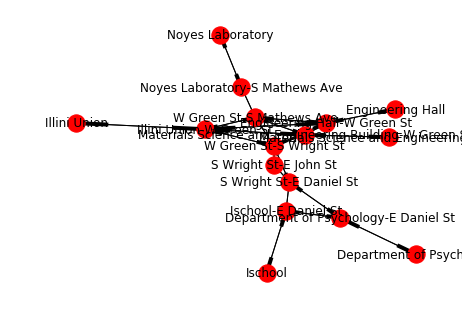

In [23]:
nx.draw(my_g,with_labels=True)

In [1]:
?print

In [4]:
x = ""
print("aha",file=x)

AttributeError: 'str' object has no attribute 'write'

In [5]:
x

''